# Deskripsi tugas: Taxi Orders Forecast

Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Buat model untuk prediksi seperti itu.

Metrik RMSE pada *test set* tidak boleh lebih dari 48.

## Instruksi tugas

1. Unduh data dan lakukan *resampling* dalam satu jam.
2. Analisis datanya.
3.  Latih model yang berbeda dengan hiperparameter yang berbeda pula. Sampel tes harus 10% dari *dataset* awal.
4. Uji data menggunakan sampel tes dan berikan kesimpulan.

## Deskripsi data

Data tersimpan di file `taxi.csv`. Jumlah pesanan di kolom'*num_orders*'.

## 1. Persiapan

In [1]:
# memuat semua library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',100)

In [2]:
#import machine learning library

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 

from xgboost import XGBRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor

import sys
print (sys.version)

3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:32:32) 
[GCC 9.3.0]


### 1.1 Memuat Data

In [3]:
# membaca berkas dan menyimpannya ke df

df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)  

In [4]:
# membuat fungsi pengolahan data

def display_information(df):
    print('Head:')
    display(df.head())
    print ('-'*100)
    print('Tail:')
    display(df.tail())
    print ('-'*100)
    print('Info:')
    print()
    display(df.info())
    print ('-'*100)
    print('Describe:')
    display(df.describe())
    print ('-'*100)
    print('Columns with nulls:')
    display(get_precent_of_na_df(df,4))
    print ('-'*100)
    print('Shape:')
    print(df.shape)
    print ('-'*100)
    print('Duplicated:')
    print('Duplicate rows:',df.duplicated().sum(),', Duplicate percentage:', (df.duplicated().sum()*100) / df.shape[0],'%')
    
def get_precent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls

print_separator = '*' * 100

In [5]:
display_information(df)
print ('-'*100)

Head:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


----------------------------------------------------------------------------------------------------
Tail:


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

----------------------------------------------------------------------------------------------------
Describe:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


----------------------------------------------------------------------------------------------------
Columns with nulls:


,Missing Values,Percent of Nulls
num_orders,0,0.0


----------------------------------------------------------------------------------------------------
Shape:
(26496, 1)
----------------------------------------------------------------------------------------------------
Duplicated:
Duplicate rows: 26415 , Duplicate percentage: 99.69429347826087 %
----------------------------------------------------------------------------------------------------


**Kesimpulan:**

* Terdapat 26415 baris yang terduplikat, yaitu 99.7% dari total dataset.

## 2. Analisis

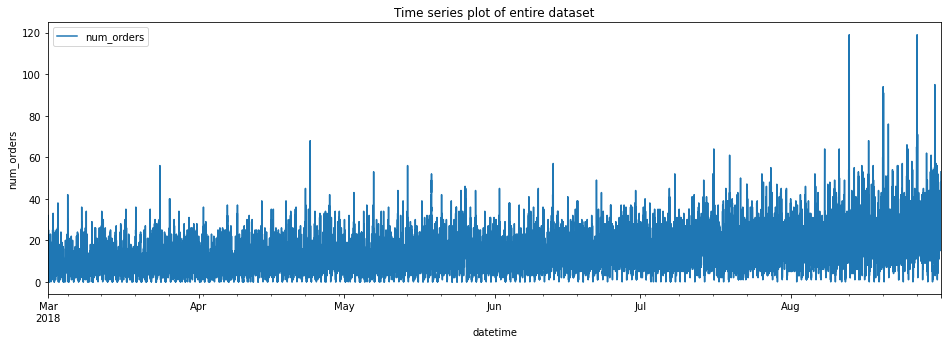

In [6]:
df.plot(figsize=(16,5))

plt.title('Time series plot of entire dataset')
plt.xlabel('datetime')
plt.ylabel('num_orders');

### 2.1 Resampling

In [7]:
# resampling data

df = df.resample('1H').sum().reset_index()
df.set_index('datetime', inplace=True)

In [8]:
# mengecek informasi data

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


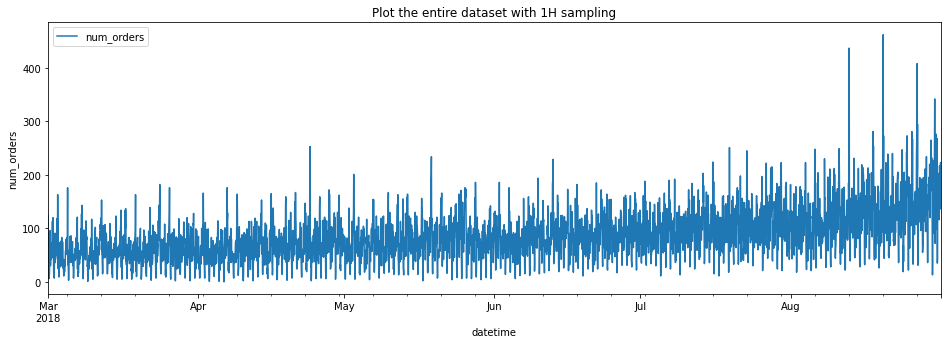

In [9]:
df.plot(figsize=(16,5))

plt.title('Plot the entire dataset with 1H sampling')
plt.xlabel('datetime')
plt.ylabel('num_orders');

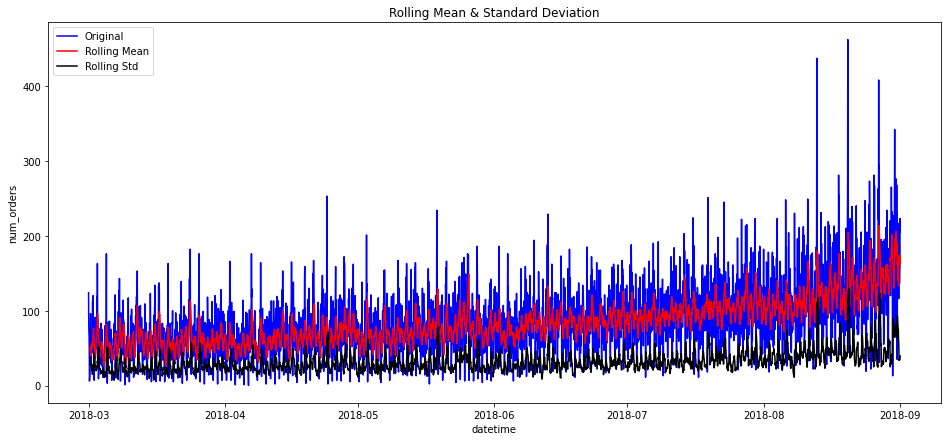

In [10]:
# menampilkan mean dan standard deviasi

roll_mean = df.rolling(10).mean()
roll_std = df.rolling(10).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

# plot rolling statistics:
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
std = plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('datetime')
plt.ylabel('num_orders')
plt.show(block=False);

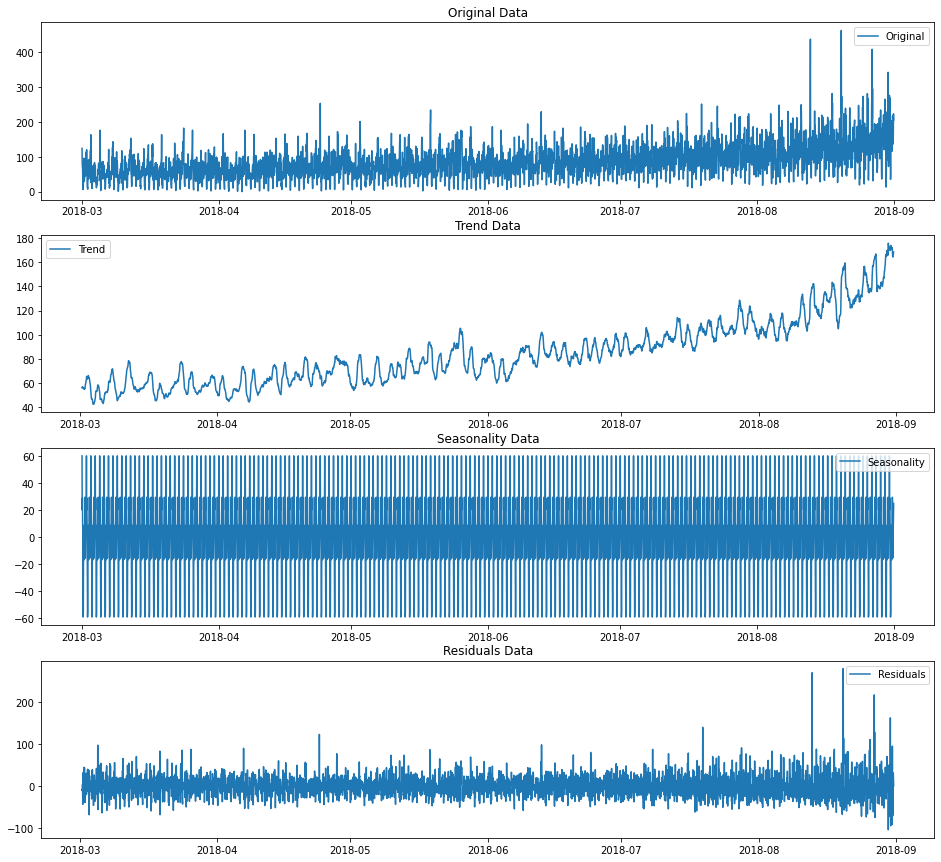

In [11]:
# menampilkan data trend dan seasonality

decomposition = seasonal_decompose(df)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,15))
plt.xlabel('datetime')
plt.ylabel('num_orders')
fig = plt.figure(1)

plt.subplot(411)
plt.title('Original Data')
plt.plot(df, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.title('Trend Data')
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.title('Seasonality Data')
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.title('Residuals Data')
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

**Kesimpulan:**
* Dari diagram di atas terlihat bahwa tren pemesanan taksi meningkat setiap bulannya, meskipun tidak terlalu signifikan pada awal bulan.

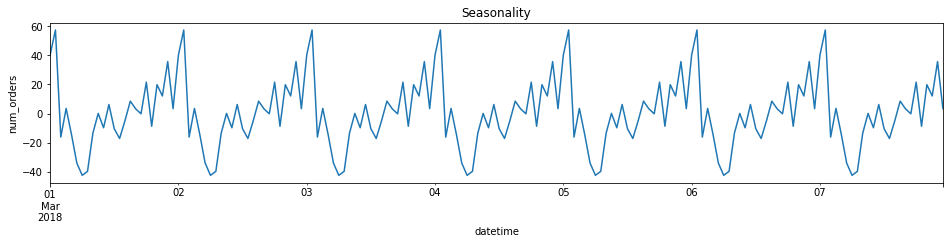

In [12]:
# resample dan menampilkan data seasonality bulan maret

decomposed_resample = seasonal_decompose(df['2018-03-01':'2018-03-07'])

plt.figure(figsize=(16,10))
plt.subplot(312)
decomposed_resample.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('datetime')
plt.ylabel('num_orders')
plt.show()

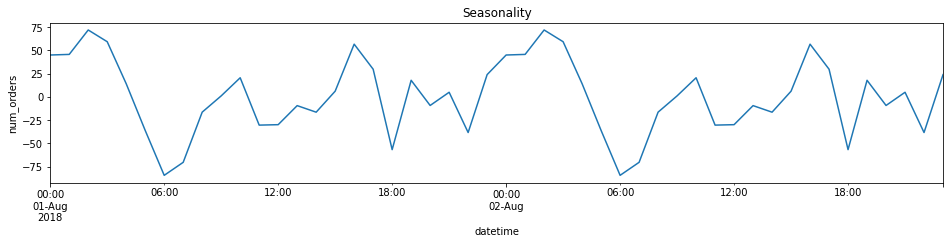

In [13]:
# resample dan menampilkan data seasonality bulan agustus

decomposed_resample = seasonal_decompose(df['2018-08-01':'2018-08-02'])

plt.figure(figsize=(16,10))
plt.subplot(312)
decomposed_resample.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('datetime')
plt.ylabel('num_orders')
plt.show()

**Kesimpulan:**
* Pengambilan resample minggu pertama bulan Maret dan dua hari pertama bulan Agustus untuk melihat distribusi data berdasarkan musiman, yang menunjukkan bahwa jumlah pemesanan taksi dari bandara mencapai puncaknya pada pukul 00:00 atau tengah malam. Hal itu bisa terjadi karena pada tengah malam taksi merupakan satu-satunya moda transportasi yang tersedia di bandara, sehingga pelanggan tidak memiliki alternatif lain.

* Pukul 6 pagi adalah waktu pemesanan taksi paling sedikit. Bisa jadi karena sebagian besar maskapai akan lepas landas saat itu, dan hanya beberapa pesawat yang mendarat di bandara tersebut.

## 3. Pelatihan

In [14]:
# membuat dataframe untuk dataframe name, model name dan model results

column_names = ['model','rmse-test','rmse-less-than-48','hyperparameters']

df_results = pd.DataFrame(columns = column_names)
display(df_results)

,model,rmse-test,rmse-less-than-48,hyperparameters


In [15]:
# def rmse function

def rmse_scorer(target: np.ndarray, predicted: np.ndarray):
  return np.sqrt(mean_squared_error(target, predicted))

rmse_scoring = make_scorer(rmse_scorer)

In [16]:
def update_results(model_name,rmse_test,rmse_lessthan_48,hyperparam,df_results):

    result_row_str = [model_name,rmse_test,rmse_lessthan_48,hyperparam]
    rows = [pd.Series(result_row_str, index=df_results.columns)]
    
    df_results = df_results.append(rows,ignore_index=True)
    
    display(df_results)
    return(df_results)

In [17]:
def evaluate_model(model,features_train,target_train,features_trial,target_trial):
    model.fit(features_train, target_train)
    predicted_trial = model.predict(features_trial)
    rmse_trial = rmse_scorer(target_trial, predicted_trial) 
    return(rmse_trial)

In [18]:
# train test split ratio (features dan target)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

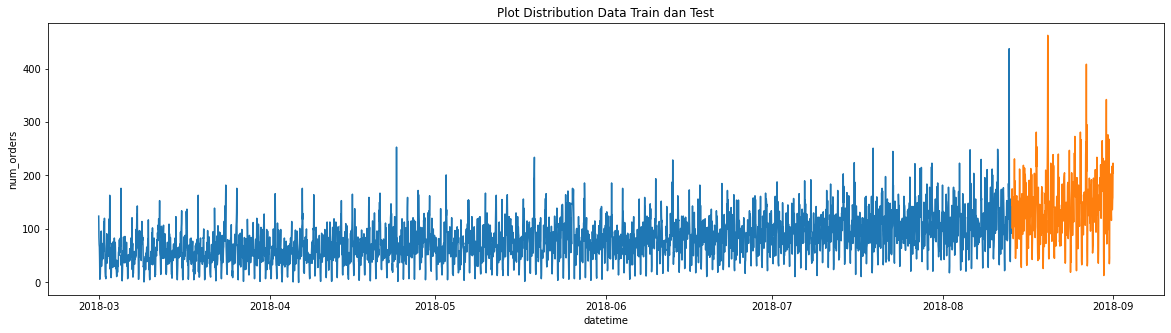

In [19]:
# menampilkan distribution data train dan test

plt.figure(figsize=(20,5))
plt.title('Plot Distribution Data Train dan Test')
sns.lineplot(features_train.index, target_train);
sns.lineplot(features_test.index, target_test);
plt.show()

### 3.1 Forecast Accuracy

In [20]:
display(df.shape)
display(df.head(5),df.tail(5))

(4416, 1)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [21]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

print("Median hourly taxi orders:", test['num_orders'].median())
fillnum = train.iloc[len(train)-1]['num_orders']
pred_previous = test.shift(fill_value = fillnum)

rmse = np.sqrt(mean_squared_error(target_test,pred_previous))
print("rmse",rmse)

Median hourly taxi orders: 135.0
rmse 58.856486242815066


**Kesimpulan:**

RMSE 58 ini berfungsi sebagai tolok ukur untuk akurasi model. Kita perlu mendapatkan prediksi yang lebih baik dari ini.

### 3.2 Features Engineering

In [22]:
# membuat features engineering

def make_features(data, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (
        df['num_orders'].shift().rolling(rolling_mean_size).mean())

make_features(df, 7, 10)
display(df.tail())

,num_orders,year,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,2018,8,31,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,173.3
2018-08-31 20:00:00,154,2018,8,31,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,166.6
2018-08-31 21:00:00,159,2018,8,31,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,162.9
2018-08-31 22:00:00,223,2018,8,31,22,4,159.0,154.0,136.0,207.0,217.0,197.0,116.0,162.1
2018-08-31 23:00:00,205,2018,8,31,23,4,223.0,159.0,154.0,136.0,207.0,217.0,197.0,170.8


## 4. Pengujian

### 4.1 Linear Regression

In [23]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [24]:
model = LinearRegression()
model.fit(features_train, target_train)

target_pred_train_lr = model.predict(features_train)
target_pred_test_lr = model.predict(features_test)

print('Root Mean Squared Error Train:', rmse_scorer(target_train, target_pred_train_lr))
print('Root Mean Squared Error Test:', rmse_scorer(target_test, target_pred_test_lr))

Root Mean Squared Error Train: 30.38102059386005
Root Mean Squared Error Test: 53.144552125418414


In [25]:
rmse_threshold = 48

model_name = 'LinearRegression'
hyperparam = 'none'
rmse_test = evaluate_model(model,features_train,target_train,features_test,target_test)
rmse_lessthan_48 = np.where(rmse_test < rmse_threshold,'Pass','Fail')
df_results = update_results(model_name,rmse_test,rmse_lessthan_48,hyperparam,df_results)

,model,rmse-test,rmse-less-than-48,hyperparameters
0,LinearRegression,53.144552,Fail,none


### 4.2 Random Forest Regressor

In [26]:
%%time

print('Random Forest Regressor')
results = defaultdict(list)

for n in [1, 2, 4, 5, 10, 17, 20]:
    model = RandomForestRegressor(random_state=12345, max_depth=n, n_estimators=100)
    model.fit(features_train, target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    results['max_depth'].append(n)
    results['train_rmse'].append(rmse_scorer(target_train, pred_train))
    results['test_rmse'].append(rmse_scorer(target_test, pred_test))
    
display(pd.DataFrame(results))

Random Forest Regressor


,max_depth,train_rmse,test_rmse
0,1,33.744041,74.252869
1,2,30.248510,68.225529
2,4,25.503005,58.000328
3,5,23.803745,53.707141
4,10,15.171655,45.776850
5,17,8.905356,45.282497
6,20,8.584981,45.090253


CPU times: user 11.3 s, sys: 54.9 ms, total: 11.4 s
Wall time: 11.4 s


In [27]:
rmse_threshold = 48

model_name = 'RandomForestRegressor'
hyperparam = 'Max_Depth = 20'
rmse_test = evaluate_model(model,features_train,target_train,features_test,target_test)
rmse_lessthan_48 = np.where(rmse_test < rmse_threshold,'Pass','Fail')
df_results = update_results(model_name,rmse_test,rmse_lessthan_48,hyperparam,df_results)

,model,rmse-test,rmse-less-than-48,hyperparameters
0,LinearRegression,53.144552,Fail,none
1,RandomForestRegressor,45.090253,Pass,Max_Depth = 20


### 4.3 CatBoost Regressor

In [28]:
%%time

print('CatBoost Regressor')
results = defaultdict(list)

for n in range(1, 6):
    model = CatBoostRegressor(loss_function='RMSE', depth=n, iterations=150, random_seed=42)
    model.fit(features_train, target_train, verbose=False)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    results['max_depth'].append(n)
    results['train_rmse'].append(rmse_scorer(target_train, pred_train))
    results['test_rmse'].append(rmse_scorer(target_test, pred_test))
    
display(pd.DataFrame(results))

CatBoost Regressor


,max_depth,train_rmse,test_rmse
0,1,24.329393,50.634886
1,2,21.022265,50.027579
2,3,19.240148,43.288354
3,4,17.867587,42.655153
4,5,16.342492,42.411110


CPU times: user 1.03 s, sys: 7.75 ms, total: 1.03 s
Wall time: 1.55 s


In [29]:
rmse_threshold = 48

model_name = 'CatBoostRegressor'
hyperparam = 'Max_Depth = 5'
rmse_test = evaluate_model(model,features_train,target_train,features_test,target_test)
rmse_lessthan_48 = np.where(rmse_test < rmse_threshold,'Pass','Fail')
df_results = update_results(model_name,rmse_test,rmse_lessthan_48,hyperparam,df_results)

Learning rate set to 0.23797
0:	learn: 35.0211117	total: 3.09ms	remaining: 460ms
1:	learn: 32.7162031	total: 5.98ms	remaining: 442ms
2:	learn: 30.3921777	total: 9.05ms	remaining: 443ms
3:	learn: 28.6802082	total: 12.2ms	remaining: 445ms
4:	learn: 27.7901444	total: 14.3ms	remaining: 415ms
5:	learn: 26.5963353	total: 16.5ms	remaining: 396ms
6:	learn: 26.0557898	total: 18.3ms	remaining: 375ms
7:	learn: 25.4602582	total: 20.5ms	remaining: 364ms
8:	learn: 24.9316940	total: 23.1ms	remaining: 362ms
9:	learn: 24.7046661	total: 25.9ms	remaining: 363ms
10:	learn: 24.6609507	total: 28.4ms	remaining: 359ms
11:	learn: 24.3105296	total: 30.3ms	remaining: 348ms
12:	learn: 24.1939131	total: 32.4ms	remaining: 342ms
13:	learn: 24.0267635	total: 34.3ms	remaining: 333ms
14:	learn: 23.9933154	total: 36.2ms	remaining: 326ms
15:	learn: 23.9609445	total: 38ms	remaining: 319ms
16:	learn: 23.6362959	total: 40ms	remaining: 313ms
17:	learn: 23.4071151	total: 42ms	remaining: 308ms
18:	learn: 23.2891128	total: 44ms

,model,rmse-test,rmse-less-than-48,hyperparameters
0,LinearRegression,53.144552,Fail,none
1,RandomForestRegressor,45.090253,Pass,Max_Depth = 20
2,CatBoostRegressor,42.411110,Pass,Max_Depth = 5


### 4.4 LightGBM Regressor

In [30]:
%%time

print('LightGBM Regressor')
results = defaultdict(list)

for n in [10, 20, 30, 50, 70, 100]:
    model = LGBMRegressor(objective='rmse', num_leaves=n, max_depth=10)
    model.fit(features_train, target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    results['num_leaves'].append(n)
    results['train_rmse'].append(rmse_scorer(target_train, pred_train))
    results['test_rmse'].append(rmse_scorer(target_test, pred_test))
    
display(pd.DataFrame(results))

LightGBM Regressor


,num_leaves,train_rmse,test_rmse
0,10,19.227443,44.646736
1,20,16.613705,43.628595
2,30,14.933973,44.150947
3,50,13.340902,43.820853
4,70,12.705365,43.817376
5,100,11.846506,43.980536


CPU times: user 2.69 s, sys: 37.5 ms, total: 2.73 s
Wall time: 2.66 s


In [31]:
rmse_threshold = 48

model_name = 'LGBMRegressor'
hyperparam = 'num_leaves = 100'
rmse_test = evaluate_model(model,features_train,target_train,features_test,target_test)
rmse_lessthan_48 = np.where(rmse_test < rmse_threshold,'Pass','Fail')
df_results = update_results(model_name,rmse_test,rmse_lessthan_48,hyperparam,df_results)

,model,rmse-test,rmse-less-than-48,hyperparameters
0,LinearRegression,53.144552,Fail,none
1,RandomForestRegressor,45.090253,Pass,Max_Depth = 20
2,CatBoostRegressor,42.411110,Pass,Max_Depth = 5
3,LGBMRegressor,43.980536,Pass,num_leaves = 100


### 4.5 XGBoost Regressor

In [32]:
%%time

print('XGBoost Regressor')
results = defaultdict(list)

for n in range(1, 6):
    model = XGBRegressor(objective='reg:squarederror', max_depth=n)
    model.fit(features_train, target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    results['max_depth'].append(n)
    results['train_rmse'].append(rmse_scorer(target_train, pred_train))
    results['test_rmse'].append(rmse_scorer(target_test, pred_test))
    
display(pd.DataFrame(results))

XGBoost Regressor


,max_depth,train_rmse,test_rmse
0,1,24.345242,50.015007
1,2,20.395284,44.938924
2,3,17.506085,45.302559
3,4,14.244080,45.710992
4,5,10.182695,45.999113


CPU times: user 6.57 s, sys: 43.7 ms, total: 6.61 s
Wall time: 6.7 s


In [33]:
rmse_threshold = 48

model_name = 'XGBRegressor'
hyperparam = 'Max_Depth = 5'
rmse_test = evaluate_model(model,features_train,target_train,features_test,target_test)
rmse_lessthan_48 = np.where(rmse_test < rmse_threshold,'Pass','Fail')
df_results = update_results(model_name,rmse_test,rmse_lessthan_48,hyperparam,df_results)

,model,rmse-test,rmse-less-than-48,hyperparameters
0,LinearRegression,53.144552,Fail,none
1,RandomForestRegressor,45.090253,Pass,Max_Depth = 20
2,CatBoostRegressor,42.411110,Pass,Max_Depth = 5
3,LGBMRegressor,43.980536,Pass,num_leaves = 100
4,XGBRegressor,45.999113,Pass,Max_Depth = 5


In [34]:
df_final = df_results.sort_values(by='rmse-test').reset_index(drop=True)
display(df_final)
print ('-'*100)

,model,rmse-test,rmse-less-than-48,hyperparameters
0,CatBoostRegressor,42.411110,Pass,Max_Depth = 5
1,LGBMRegressor,43.980536,Pass,num_leaves = 100
2,RandomForestRegressor,45.090253,Pass,Max_Depth = 20
3,XGBRegressor,45.999113,Pass,Max_Depth = 5
4,LinearRegression,53.144552,Fail,none


----------------------------------------------------------------------------------------------------


## Kesimpulan Akhir:

berdasarkan hasil di atas:
- Dari beberapa model training yang dilakukan, ditemukan model terbaik pada model CatBoostRegressor dengan parameter max_dept = 5.
- Model CatBoostRegressor ini memiliki nilai rmse yang paling rendah pada hasil test yaitu 42, meskipun memiliki perbedaan yang cukup jauh dengan hasil rmse dari data train.
- Model LinearRegression memiliki nilai rmse yang paling tinggi pada hasil test yaitu 53.

In [35]:
print("Thank you for evaluating my project, Looking forward to your feedback")

Thank you for evaluating my project, Looking forward to your feedback


# Daftar Periksa Penilaian

- [x]  Jupyter Notebook bisa dibuka.
- [ ]  Tidak ada kesalahan dalam kode
- [ ]  Sel-sel dengan kode telah disusun berdasarkan urutan eksekusi.
- [ ]  Data telah diunduh dan disiapkan
- [ ]  Data telah dianalisis
- [ ]  Model sudah dilatih dan hiperparameter sudah dipilih
- [ ]  Model sudah dievaluasi. Kesimpulan sudah ada.
- [ ] *RMSE* untuk *test set* tidak lebih dari 48